<a href="https://colab.research.google.com/github/kimj98/AB-Testing-Projects/blob/main/Ecommerce_AB_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from google.colab import files
myfile = files.upload()


Saving ab_data.csv to ab_data.csv


In [ ]:
import pandas as pd

In [ ]:
data =pd.read_csv("ab_data.csv")
data

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1
...,...,...,...,...,...
294475,734608,45:03.4,control,old_page,0
294476,697314,20:29.0,control,old_page,0
294477,715931,40:24.5,treatment,new_page,0
294478,759899,20:29.0,treatment,new_page,0


Data Preprocessing

In [ ]:
data.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

In [ ]:
data.sort_values("timestamp",inplace = True)
data.head()

,user_id,timestamp,group,landing_page,converted
53529,825480,00:00.0,control,old_page,0
123148,653457,00:00.0,control,old_page,0
128342,731946,00:00.0,control,old_page,0
45680,817555,00:00.0,control,old_page,0
30513,799074,00:00.0,treatment,new_page,0


In [ ]:
len(data)

294480

In [ ]:
len(data.user_id.unique())

290585

There are total 294480 records of data, and there are total of 290585 unique user id which means that there are some records that include multiple user session. 

In [ ]:
unqie_user_session = data.groupby("user_id").converted.count()
multiple_session_user = list(unqie_user_session[unqie_user_session>1].index)

In [ ]:
data[data.user_id.isin(multiple_session_user)].sort_values("user_id")

,user_id,timestamp,group,landing_page,converted
213114,630052,25:54.1,treatment,old_page,1
230259,630052,16:05.2,treatment,new_page,0
251762,630126,16:00.3,treatment,new_page,0
22513,630126,35:54.8,treatment,old_page,0
183371,630137,08:49.9,control,old_page,0
...,...,...,...,...,...
99479,945703,39:31.3,control,old_page,0
40370,945797,04:49.4,control,new_page,1
186960,945797,23:21.8,control,old_page,0
131756,945971,43:54.1,control,new_page,0


By looking in to user id that has multiple session, most of these user's group and landing page does not match. First I will try to remove all the user_id that were exposed to both old page and new page. Also I will remove users that has multiple session and unmatching group and landing page. After cleaning the data, there is total of 286690 records of data, each being a unique session from unique user

In [ ]:
#remove multiple session user
data = data[~data['user_id'].isin(multiple_session_user)]
#when group is control the landing page should be old page and if group is in treatment then the landing page should be new page
data = data[((data["group"]== "control") & (data["landing_page"]=="old_page")) | ((data["group"]== "treatment") & (data["landing_page"]=="new_page"))]
len(data)

286690

In [ ]:
#check if there is abnormal values in each columns
feature = {}
for i in data.columns[2:]:
  unique_val = data[i].unique()
  feature[i] = list(unique_val)
feature

{'converted': [0, 1],
 'group': ['control', 'treatment'],
 'landing_page': ['old_page', 'new_page']}

#AB Testing

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
conversions = data.groupby("group").converted.mean().reset_index()

In [ ]:
data.group.value_counts()/len(data)

treatment    0.500181
control      0.499819
Name: group, dtype: float64

In [ ]:
control_conversion = conversions.converted[0]
treatment_conversion = conversions.converted[1]
control_conversion,treatment_conversion

observed_differece = treatment_conversion - control_conversion
observed_differece

-0.001447017918889515

In [ ]:
ab_data = data[["group","converted"]]
ab_data.head()

,group,converted
53529,control,0
123148,control,0
128342,control,0
45680,control,0
30513,treatment,0


The metric that will be used in this ab testing will be the difference of conversion between the control group and the treatment group. As seen above, the porportion of the treatment and control group are rougly the same and the observed difference turns out to be around -0.001 which shows that even the treatment shows that there was no improvement on the conversion. Still I will proceed the ab testing to find out the p value for our observed difference using permutation test.


Null hypothesis: The treatment group will show no uplift in conversion rate and that any positive difference is simply due to random chance
Alternative hypothesis: The treatment group will show an uplift in conversion rate and that the difference is due to an actual positive result from the treatment

In [ ]:
def find_metric(data):
  conversions = data.groupby("group").converted.mean().reset_index()
  control_conversion = conversions.converted[0]
  treatment_conversion = conversions.converted[1]
  observed_differece = treatment_conversion - control_conversion
  return observed_differece

In [ ]:
def sampling_distribution(data,n):
  vals = []
  shuffled_data  =  data
  for i in np.arange(n):
    shuffled_group = data.sample(n = len(data),replace = False)["group"]
    shuffled_data["group"] = shuffled_group.values
    shuffled_data = shuffled_data[["group","converted"]]
    difference = find_metric(shuffled_data)
    vals.append(difference)
  return vals
  

In [ ]:
def find_pval(sampling_distribution,observed):
  p_val = np.mean([i>observed_differece for i in sampling_distribution])
  return p_val
  

In [ ]:
sampling_distribution = sampling_distribution(data, 10000)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


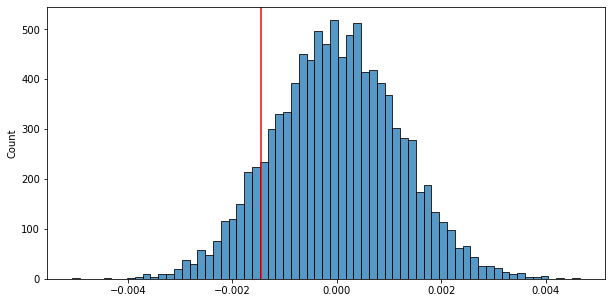

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(sampling_distribution)
plt.axvline(observed_differece, color = 'r')

In [ ]:
p_value = find_pval(sampling_distribution, observed_differece)
p_value

0.8

The p value of our observed difference is 0.8 which is a very high percentage. This means that in random chance the control group can show a better conversion uplift than the observed value 80% of the time. Also since the observed value is negative, we can conclude to reject the alternative hypothesis and support the null hypothesis. 

# AB Testing Peeking Experiment

In [ ]:
data

,user_id,timestamp,group,landing_page,converted
53529,825480,00:00.0,control,old_page,0
123148,653457,00:00.0,control,old_page,0
128342,731946,00:00.0,control,old_page,0
45680,817555,00:00.0,control,old_page,0
30513,799074,00:00.0,treatment,new_page,0
...,...,...,...,...,...
53535,843186,59:59.9,treatment,old_page,0
201199,807414,59:59.9,treatment,new_page,0
77669,805084,59:59.9,control,new_page,0
170660,642381,59:59.9,control,new_page,0
